In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = "data/"

In [3]:
batch_size = 32
img_height = 175
img_width = 101

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/trainDataSet',   
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6186 files belonging to 24 classes.
Using 4949 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "data/validationDataSet",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6179 files belonging to 24 classes.
Using 1235 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['1', '11', '12', '13', '14', '15', '16', '17', '18', '2', '21', '23', '24', '27', '28', '3', '31', '33', '34', '4', '5', '6', '7', '9']


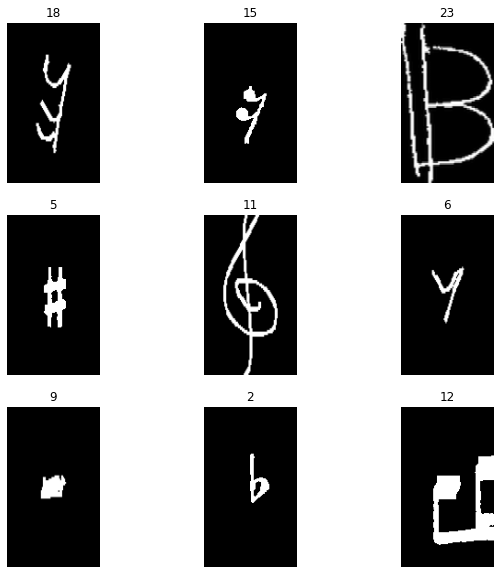

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes = 24

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 175, 101, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 175, 101, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 12, 64)        0

In [14]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
155/155 [==============================] - 52s 329ms/step - loss: 1.3045 - accuracy: 0.6398 - val_loss: 0.3483 - val_accuracy: 0.8883
Epoch 2/10
155/155 [==============================] - 45s 289ms/step - loss: 0.1603 - accuracy: 0.9513 - val_loss: 0.2379 - val_accuracy: 0.9239
Epoch 3/10
155/155 [==============================] - 45s 288ms/step - loss: 0.0639 - accuracy: 0.9806 - val_loss: 0.2935 - val_accuracy: 0.9239
Epoch 4/10
155/155 [==============================] - 45s 291ms/step - loss: 0.0400 - accuracy: 0.9867 - val_loss: 0.3077 - val_accuracy: 0.9328
Epoch 5/10
155/155 [==============================] - 44s 282ms/step - loss: 0.0253 - accuracy: 0.9929 - val_loss: 0.4247 - val_accuracy: 0.9174
Epoch 6/10
155/155 [==============================] - 44s 281ms/step - loss: 0.0244 - accuracy: 0.9906 - val_loss: 0.3348 - val_accuracy: 0.9239
Epoch 7/10
155/155 [==============================] - 44s 285ms/step - loss: 0.0235 - accuracy: 0.9958 - val_loss: 0.4385 - val_ac

In [15]:
model.save('model1.h5')

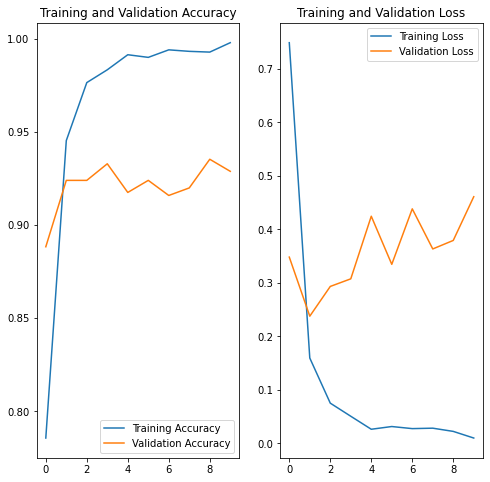

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

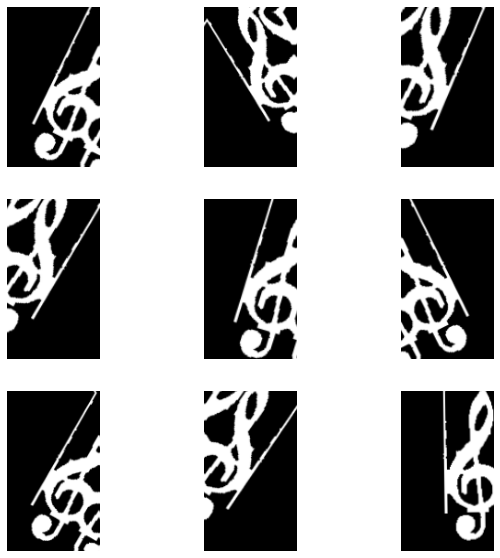

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 175, 101, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 175, 101, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 175, 101, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 87, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 25, 64)       

In [22]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
155/155 [==============================] - 59s 375ms/step - loss: 2.1593 - accuracy: 0.3627 - val_loss: 0.8151 - val_accuracy: 0.7611
Epoch 2/30
155/155 [==============================] - 56s 359ms/step - loss: 0.7557 - accuracy: 0.7649 - val_loss: 0.5619 - val_accuracy: 0.8194
Epoch 3/30
155/155 [==============================] - 55s 357ms/step - loss: 0.5089 - accuracy: 0.8464 - val_loss: 0.4272 - val_accuracy: 0.8680
Epoch 4/30
155/155 [==============================] - 55s 354ms/step - loss: 0.3994 - accuracy: 0.8784 - val_loss: 0.4213 - val_accuracy: 0.8826
Epoch 5/30
155/155 [==============================] - 55s 354ms/step - loss: 0.3666 - accuracy: 0.8868 - val_loss: 0.3813 - val_accuracy: 0.8842
Epoch 6/30
155/155 [==============================] - 55s 356ms/step - loss: 0.3043 - accuracy: 0.9092 - val_loss: 0.2914 - val_accuracy: 0.9045
Epoch 7/30
155/155 [==============================] - 56s 359ms/step - loss: 0.2393 - accuracy: 0.9252 - val_loss: 0.2915 - val_ac

In [23]:
model.save('model2.h5')

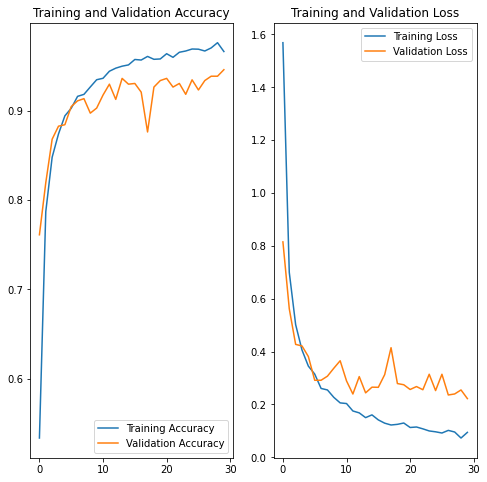

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

img = keras.preprocessing.image.load_img(
    'data/trainDataSet/2/josep_BN_88.png', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score*100)

print(
    "This image most likely belongs to class {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

tf.Tensor(
[1.2971557e-18 1.4261190e-05 1.0719944e-11 1.1310792e-12 3.3266513e-24
 2.9625261e-11 4.3306238e-07 5.6511842e-18 1.6481158e-13 9.9958321e+01
 2.5754529e-08 3.6230991e-05 3.3336665e-15 2.4750148e-18 8.1130489e-14
 4.1633572e-02 2.0241178e-21 1.5418215e-18 2.5852142e-14 1.9761770e-10
 1.3864051e-06 2.2747845e-16 1.3521621e-10 2.7234539e-16], shape=(24,), dtype=float32)
This image most likely belongs to class 2 with a 99.96 percent confidence.
